In [1]:
from os import getenv
import eth_abi
import pandas as pd
import matplotlib.pyplot as plt
from utils.rpc import RPC
from utils.helper import read_file_json, chunk_list
from datetime import datetime
from dotenv import load_dotenv
from db.postgre import Postgres 
from hexbytes import HexBytes


load_dotenv()

True

In [2]:
RPC_URL = 'http://10.7.0.58:8545'
DSN_POSTGRES = getenv('DSN_POSTGRES')

START_TIME = 1724095319 # 2024-08-19 19:21:59 GMT
END_TIME = 1726773719 # 2024-09-19 19:21:59 GMT+0

In [3]:
rpc = RPC(RPC_URL)
db = Postgres(DSN_POSTGRES)

In [4]:
# Database bundles time range query
oldest_timestamp = datetime.fromtimestamp(db.query('SELECT MIN(timestamp) FROM bundles')[0][0])
latest_timestamp = datetime.fromtimestamp(db.query('SELECT MAX(timestamp) FROM bundles')[0][0])
print(f'Time range from {oldest_timestamp} to {latest_timestamp}')

Time range from 2022-09-15 13:43:47 to 2024-09-20 02:21:59


In [5]:
# count record in bundles table
count_record = db.query(f"""
    SELECT COUNT(1) 
    FROM bundles 
    WHERE timestamp >= {START_TIME} AND timestamp <= {END_TIME} 
""")[0][0]

print('Count record ', count_record)

Count record  120207


In [ ]:
# count arb
count_arb = db.query(f"""
    SELECT COUNT(*)
    FROM (
        SELECT b.bundle_hash
        FROM bundles b
        JOIN txs t ON b.bundle_hash = t.bundle_hash
        WHERE b.timestamp BETWEEN {START_TIME} AND {END_TIME}
        GROUP BY b.bundle_hash
        HAVING COUNT(t.tx_hash) <= 2
    ) AS filtered_bundles;
""")[0][0]

print('Count arb ', count_arb)

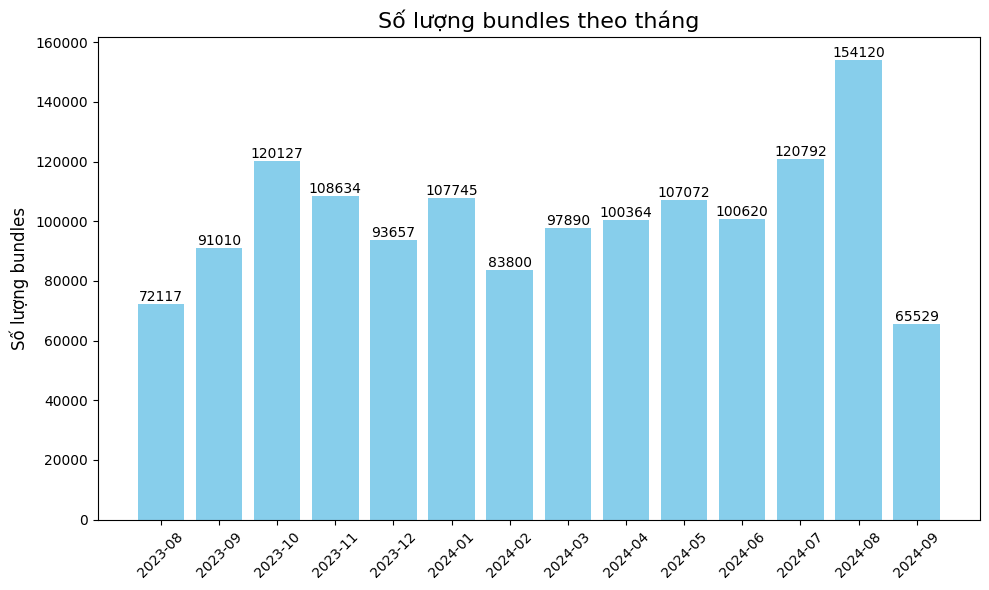

In [5]:
# Plot count bundle by month

bundles_by_month = db.query(f"""
    SELECT 
        date_trunc('month', to_timestamp(timestamp)) AS month,
        COUNT(1) AS bundle_count
    FROM bundles
    GROUP BY month
""")

df = pd.DataFrame(bundles_by_month, columns=['month', 'bundle_count'])
df['month'] = pd.to_datetime(df['month']).dt.strftime('%Y-%m')

plt.figure(figsize=(10, 6))
plt.bar(df['month'], df['bundle_count'], color='skyblue')
bars = plt.bar(df['month'], df['bundle_count'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, 
             ha='center', va='bottom', fontsize=10)
    
plt.title('Số lượng bundles theo tháng', fontsize=16)
plt.ylabel('Số lượng bundles', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
bundles = []
offset = 0

while True:
    rows = db.query(f"""
        WITH filtered_bundles AS (
            SELECT b.bundle_hash
            FROM bundles b
            JOIN txs t ON b.bundle_hash = t.bundle_hash
            WHERE b.timestamp BETWEEN {START_TIME} AND {END_TIME}
            GROUP BY b.bundle_hash
            HAVING COUNT(t.tx_hash) <= 2
            LIMIT 5000
            OFFSET {offset}
        )
        SELECT b.bundle_hash, b.searcher_txs, t.tx_hash, t.to, t.input, b.profit_usdc
        FROM bundles b
        JOIN filtered_bundles fb ON b.bundle_hash = fb.bundle_hash
        JOIN txs t ON b.bundle_hash = t.bundle_hash
    """)
    
    if len(rows) == 0:
        break
    bundles.extend(rows)
    offset += 5000
    
df = pd.DataFrame(bundles, columns=['bundle_hash', 'searcher_txs', 'tx_hash', 'to', 'input', 'profit_usdc'])

In [7]:
df_exploded = df.explode('searcher_txs')
df_in_searcher_txs = df_exploded[df_exploded['tx_hash'].isin(df_exploded['searcher_txs'])].copy()
df_in_searcher_txs['is_v3'] = False
df_not_in_searcher_txs = df[~df['tx_hash'].isin(df_exploded['searcher_txs'])].copy()


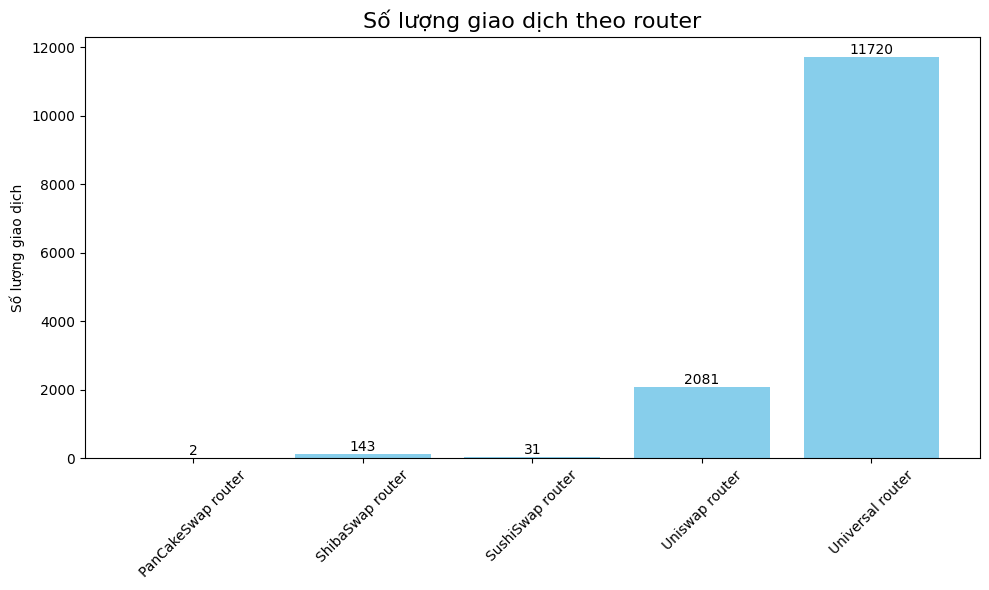

In [8]:
ROUTER_ADDRESS = {
    '0x03f7724180aa6b939894b5ca4314783b0b36b329': 'ShibaSwap router',
    '0xceb90e4c17d626be0facd78b79c9c87d7ca181b3': 'CrossSwap router',
    '0xeff92a263d31888d860bd50809a8d171709b7b1c': 'PanCakeSwap router',
    '0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f': 'SushiSwap router',
    '0x7a250d5630b4cf539739df2c5dacb4c659f2488d': 'Uniswap router',
    '0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad': 'Universal router',
}

df_not_in_searcher_txs['router_name'] = df_not_in_searcher_txs['to'].map(ROUTER_ADDRESS)
df1 = df_not_in_searcher_txs.groupby('router_name').size().reset_index(name='tx_count')

plt.figure(figsize=(10, 6))
plt.bar(df1['router_name'], df1['tx_count'], color='skyblue')
bars = plt.bar(df1['router_name'], df1['tx_count'], color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')
plt.ylabel('Số lượng giao dịch')
plt.title('Số lượng giao dịch theo router', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
BLACKLIST = read_file_json('../config/blacklist.json')
BLACKLIST_METHOD = {
    '0x908fb5ee': "Balancer",
    '0x2170c741': "Balancer",
    "0x0d7d75e0": "Balancer FlashLoan",
}

def chunk_batch(method, txs: list[str], chunk_size: int) -> list[dict]:
    txs_chunk = chunk_list(txs, chunk_size)
    result = []
    for txs in txs_chunk:
        result.extend(method(txs))
    return result

def filter_v2(bundles: list) -> list[dict]:
    bundles_searcher_map = {b['searcher_tx']: b for b in bundles}
    txs_receipt = chunk_batch(rpc.batch_get_transaction_receipt, list(bundles_searcher_map.keys()), 50)

    def filter_tx_receipt(receipt) -> bool:
        if receipt['status'] != '0x1':
            return False

        v3_data_types = ['int256', 'int256', 'uint160', 'uint128', 'int24']
        for l in receipt['logs']:
            address = l['address']
            if address in BLACKLIST:
                return False

            if l['topics'][0][:10] in BLACKLIST_METHOD:
                return False

            try:
                eth_abi.decode(v3_data_types, HexBytes(l['data']))
                return False
            except Exception:
                pass

        return True

    txs_receipt_filter = list(filter(filter_tx_receipt, txs_receipt))
    result = []
    for tx in txs_receipt_filter:
        result.append(bundles_searcher_map[tx['transactionHash']])
    return result

In [9]:
CHUNK_SIZE = 50
for i in range(0, len(df), CHUNK_SIZE):
    tx_hashes = df_in_searcher_txs['tx_hash'].iloc[i:i+CHUNK_SIZE].tolist()
    receipts = rpc.batch_get_tx_receipts(tx_hashes)
    for r in receipts:
        if r is not None and r['status'] == '0x1':
            


0x29985c584d3ce2a3e446b107bbc04aa2082c1c3f52c23f448b2d215cb632ef40
0x349a723cc92e23c194ead53d8ebb5418b5154d42704ebb4b3ee841ac24c1e2de
0xc2aa1c146798984e66f90ec586144fda6c14e8e64e518cccffc4cc74ffafc835
0x7bf63768d6f0ca56b2fb45639d3c2859932173daefc28df161b7125bf7df0b90
0x38a64673b46bb41ddcd9d2e88a521a5a04f3bab820d66c9a723b2c382f377389
0x5f3a5612f0d83e9ae757190a9b545d14eac2d9d86415f0476ff0ac2352bb2171
0x5604c63c0682e3d0c9c7466d4eb1189e7c869c61e2facf5f541ffc941c00ad1d
0x4dfe336ecbc72052d209d17f2c4ed5a30c0b588be88c393bd4e4bbd4f6af00d2
0x114a1842e90bf20e71e7e424f170459bcefed3982d9d576200ba9150455ca8a3
0xf5d04fbc754e803912529d5f37275e712764ede6f9694a5046ac783e3ee7897c
0x78564704d02b59f9757d860e28ce06627cf81fe3314af1f764b619f0daeae784
0x36eac193d51f02eefc63f4ee89c98573b15911be139b1d2ad61975c5e93ce180
0xb22dad5cf9eef1255aff41e10db8764043f2b6a59cb3ceb895d96f5debf32ce9
0x743b8c9f15f5d5b17b464073bdcc29e7c3cba82a029fa950b18baf87b613e79a
0x033260fb9bdc9ae62fe0bd2567e54de8de8e69f6c366ce76d2e7a855a265

KeyboardInterrupt: 